## Age and Ethnicity GAN
### GANs with and without distribution
#### Diana and David

In [1]:
# import packages

import seaborn as sns
import matplotlib.pyplot as plt

import sys
import numpy as np
import tensorflow.keras as keras
import tensorflow.keras.backend as K
from tensorflow.keras.layers import Input, Dense, Activation, LeakyReLU, BatchNormalization, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Model
import matplotlib.pyplot as plt
import pandas as pd
import os
import itertools
import math

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
import tensorflow as tf

import seaborn as sns
import matplotlib.pyplot as plt

pd.set_option('display.max_rows', None)

In [2]:
# if connecting to Colab, connect to Google Drive with this code:

#from google.colab import drive
#drive.mount('/content/drive')

In [3]:
# the skeleton of this code is derived from the following tutorial:

# https://keras.io/examples/generative/conditional_gan/#interpolating-between-classes-with-the-trained-generator

## Create the cGAN class along with some important functions to be used throughout the notebook

In [4]:
# create the conditional GAN

class ConditionalGAN(keras.Model):
    def __init__(self, noise_dim=50, 
                 data_shape=1,
                 num_classes=3, 
                 d_learning_rate=1e-5, 
                 g_learning_rate=1e-6, 
                 batch_size=64, 
                 start_epoch=0,
                 verbose = False, distribute = False):

        super(ConditionalGAN, self).__init__()
        self.noise_dim = noise_dim
        self.data_shape = data_shape # output shape of the generator and goes to discriminator
        self.num_classes = num_classes
        self.d_optimizer = tf.keras.optimizers.Adam(d_learning_rate)
        self.g_optimizer = tf.keras.optimizers.Adam(g_learning_rate)
        self.batch_size = batch_size
        self.start_epoch = start_epoch
        self.verbose = verbose
        self.distribute = distribute

        self.gen_loss_tracker = keras.metrics.Mean(name="generator_loss")
        self.disc_loss_tracker = keras.metrics.Mean(name="discriminator_loss")

        # add number of class labels to the input channels for generator
        self.g_dim = self.noise_dim + self.num_classes

        # add the number of class labels to the input to the discriminator
        self.d_dim = self.data_shape + self.num_classes

        if (self.verbose):
            print("Generator input dim: ", self.g_dim)
            print("Dicrimination input dim: ", self.d_dim)


        # build generator and discriminator
        self.discriminator = self.build_discriminator()
        self.generator = self.build_generator()

    @property
    def metrics(self):
        return [self.gen_loss_tracker, self.disc_loss_tracker]
    
    def build_generator(self):
        "Build the generator model"
        inputs = Input(shape=(self.g_dim,))
        hidden = Dense(64)(inputs) # 128
        hidden = LeakyReLU(alpha=0.2)(hidden)
        hidden = BatchNormalization()(hidden)
        hidden = Dense(64)(hidden)
        hidden = LeakyReLU(alpha=0.2)(hidden)
        hidden = BatchNormalization()(hidden) # added 
        hidden = Dense(64)(hidden) # added 
        hidden = LeakyReLU(alpha=0.2)(hidden)
        
        output = Dense(self.data_shape, activation="sigmoid")(hidden)
        #output = Dense(self.data_shape, activation="linear")(hidden)
        
        # add the ability to distribute the generator
        
        if self.distribute == False: 
          generator = Model(inputs=inputs, outputs=output, name="generator")

        elif self.distribute == 'G' or self.distribute.lower() == 'both':
          mirrored_strategy = tf.distribute.experimental.MultiWorkerMirroredStrategy() #tf.distribute.MirroredStrategy()
          with mirrored_strategy.scope():

            generator = Model(inputs=inputs, outputs=output, name="generator")
            print('Number of devices: {}'.format(mirrored_strategy.num_replicas_in_sync))
            
        else:
            print('Unrecognized distribution call. Reverting to non distributed GAN.')
            generator = Model(inputs=inputs, outputs=output, name="generator")

        generator.summary()
        return generator


    def build_discriminator(self):
        "build the discriminator model"
        d_inputs = Input(shape=(self.d_dim,))
        h = Dense(64, input_shape=(self.g_dim,))(d_inputs) 
        h = LeakyReLU(alpha=0.2)(h)
        h = Dropout(0.1)(h)
        h = Dense(64)(h) #32
        h = LeakyReLU(alpha=0.2)(h)
        h = Dropout(0.1)(h)
        h = Dense(64)(h) #32 # added
        h = LeakyReLU(alpha=0.2)(h) # added
        h = Dropout(0.1)(h) # added
        h = Dense(1, activation="sigmoid")(h)
        
        # add the ability to distribute the discriminator
        
        if self.distribute == False:
          discriminator = Model(d_inputs, h, name="discriminator")

        elif self.distribute == 'D' or self.distribute.lower() == 'both':
          mirrored_strategy = tf.distribute.experimental.MultiWorkerMirroredStrategy() #tf.distribute.MirroredStrategy()
          with mirrored_strategy.scope():
            discriminator = Model(d_inputs, h, name="discriminator")
            print('Number of devices: {}'.format(mirrored_strategy.num_replicas_in_sync))
            
        else:
            print('Unrecognized distribution call. Reverting to non distributed GAN.')
            discriminator = Model(inputs=inputs, outputs=output, name="generator")      


        discriminator.summary()
        return discriminator

    def compile(self, loss_fn):
        super(ConditionalGAN, self).compile()
        self.loss_fn = loss_fn

    def train_step(self, data):
        # Unpack the data.
        real_ages, one_hot_labels = data
        real_ages = tf.cast(real_ages, tf.float32)
        #print("real_ages:", real_ages[0:2])

        # Add dummy dimensions to the labels so that they can be concatenated with
        # the images. This is for the discriminator.
        age_one_hot_labels = one_hot_labels[:, None]
        print("age_one_hot_labels1:", age_one_hot_labels[0:2])

        age_one_hot_labels = tf.repeat(age_one_hot_labels, repeats=[1])
        print("age_one_hot_labels2:", age_one_hot_labels[0:2])

        age_one_hot_labels = tf.reshape(age_one_hot_labels, (-1, self.num_classes))
        age_one_hot_labels = tf.cast(age_one_hot_labels, tf.float32)
        print("age_one_hot_labels3:", age_one_hot_labels[0:2])

        # Sample random points in the latent space and concatenate the labels.
        # This is for the generator.
        batch_size = tf.shape(real_ages)[0]
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.noise_dim))
        random_vector_labels = tf.concat([random_latent_vectors, one_hot_labels], axis=1)

        # Decode the noise (guided by labels) to fake ages.
        generated_ages = self.generator(random_vector_labels)
        generated_ages= tf.cast(generated_ages, tf.float32)

        # Combine them with real images. Note that we are concatenating the labels
        # with these images here. and tf.concat is on the last dimension (-1)
        fake_ages_and_labels = tf.concat([generated_ages, age_one_hot_labels], -1)
        real_ages_and_labels = tf.concat([real_ages, age_one_hot_labels], -1) 
        combined_ages = tf.concat([fake_ages_and_labels, real_ages_and_labels], axis=0)

        # Assemble labels discriminating real from fake ages. 1 == fake, 0 == real
        labels = tf.concat(
            [tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0
        )
        
        #labels = tf.random.shuffle(labels, seed = 24)

        # Train the discriminator.
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_ages)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )

        # Sample random points in the latent space.t
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.noise_dim))
        random_vector_labels = tf.concat(
            [random_latent_vectors, one_hot_labels], axis=1
        )

        # Assemble labels that say "all real images".
        misleading_labels = tf.zeros((batch_size, 1))

        # Train the generator (note that we should *not* update the weights
        # of the discriminator)!
        with tf.GradientTape() as tape:
            fake_ages = self.generator(random_vector_labels)
            fake_ages_and_labels = tf.concat([fake_ages, age_one_hot_labels], -1)
            predictions = self.discriminator(fake_ages_and_labels)
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        # Monitor loss.
        self.gen_loss_tracker.update_state(g_loss)
        self.disc_loss_tracker.update_state(d_loss)
        return {
            "g_loss": self.gen_loss_tracker.result(),
            "d_loss": self.disc_loss_tracker.result(),
        }
    
    #######################
    
    ## function graveyard
    
    # this function creates a list of arrays with every possible position of one 1 and remaining 0s
    '''
    def create_zeros(size):
        
      a = []

      for i in range(size):
        b = [0] * size
        b[i] = 1
        a.append(b)
      return a
      '''


    '''def generate(self, n=1000, one_hot_label=[1., 0., 0., 0., 0., 0., 1., 0.]):
        """Generate n ages for a class"""
        print("Generating: ", n, " ages for unit type: ", one_hot_label)
        input_noise = tf.random.normal((n, self.noise_dim), 0, 1)
        random_vector_labels = tf.concat([input_noise, one_hot_label], axis=1)

        ages = self.generator(random_vector_labels)

        return ages.numpy()'''
    
    

## Function used to generate data and display statistics on the data output

In [5]:
def generate_table(df, features = ['ethnicity', 'gender'], cont_feats = ['age']):
    
  i = 0
  l = [] 

  encoder = OneHotEncoder(handle_unknown='ignore', categories = 'auto') # OHE sklearn initiate
  encoder.fit_transform(df_feats[features]).toarray()
    
  encoder_df = pd.DataFrame(encoder.fit_transform(df_feats[features]).toarray(), columns = encoder.get_feature_names(features))

  # merge one-hot encoded columns back with original DataFrame
  final_df = df_feats.join(encoder_df)
  #final_df.columns = encoder.get_feature_names(features)
    

  for j in np.unique(encoder.fit_transform(df_feats[features]).toarray(), axis=0):


    """Generate n elements for a class"""
    print('_'*30)
    print("Generating: ", df.groupby(features).count().iloc[i][0], " data elements with categorical vars: ", 
          df.groupby(features).count().iloc[i].name)

    age_one_hot_labels = tf.repeat([j],df.groupby(features).count().iloc[i][0], axis=0)
    input_noise = tf.random.normal((df.groupby(features).count().iloc[i][0], cgan.noise_dim), 0, 1)
    random_vector_labels = tf.concat([input_noise, tf.cast(age_one_hot_labels, dtype=tf.float32)], axis=1)
    
    gen_data = cgan.generator(random_vector_labels)

    f_dict = {} # dictionary to hold info cat vars
    for m in range(len(features)):
      f_dict[m] = df.groupby(features).count().iloc[i].name[m]


    # create query to specify each possibility of cat combonations
    q = ''
    for m in range(len(features)):
      q += features[m] + " == '" + f_dict[m] +"' &"
    q = q[:-1]

    df_feats_class = final_df.query(q)

    df_temp = pd.DataFrame(columns = cont_feats + features)

    di_cont = {} # dictionary to hold continuous vars

    if i == 0:
      df_age_eth = pd.DataFrame(columns = cont_feats + features)

    k = 0
    for c in cont_feats:

      print(' ')
      input_noise = tf.random.normal((df.groupby(features).count().iloc[i][0], cgan.noise_dim), 0, 1)
      random_vector_labels = tf.concat([input_noise, tf.cast(age_one_hot_labels, dtype=tf.float32)], axis=1)
      
      gen_data = cgan.generator(random_vector_labels)

      mean_filtered = df[c].mean()
      std_filtered =  df[c].std()
      min_filtered =  df[c].min()
      max_filtered =  df[c].max()

      scaled_filtered = [(x - min_filtered)/(max_filtered - min_filtered) for x in df[c]]
      scaled_filtered = [0 if math.isnan(x) else x for x in scaled_filtered]
      all = np.reshape(scaled_filtered, (-1, 1))
      di_cont[k] = all
      inv_gen_ages = [(val * (max_filtered-min_filtered)) + min_filtered for val in gen_data.numpy().flatten()]
      df_temp[c] = inv_gen_ages

      print("Generated statistics for continuous var <", c, ">:")
      print("min: ", np.min(inv_gen_ages))
      print("mean: ", np.mean(inv_gen_ages))
      print("max: ", np.max(inv_gen_ages))
      print("stdv: ", np.std(inv_gen_ages))
      print(' ')

      print("Statistics of real data for continuous var <", c, ">:")
      print("min: ", np.min(df_feats_class[c]))
      print("mean: ", np.mean(df_feats_class[c]))
      print("max: ", np.max(df_feats_class[c]))
      print("stdv: ", np.std(df_feats_class[c]))
      k += 1

      
    #i+=1

    #inv_gen_ages = [(val * (max_filtered-min_filtered)) + min_filtered for val in ages.numpy().flatten()]

    #df_temp[cont_feats] = inv_gen_ages

    for f in range(len(features)):
      df_temp[features[f]] = f_dict[f]
      #df_temp['gender'] = gen
      #print(df_temp)

    df_age_eth = df_age_eth.append(df_temp)
    i+=1
    print(' ')

  return df_age_eth, final_df
  '''
      sns.histplot(inv_gen_ages, bins=70, label='GAN', kde=True,)
      sns.histplot(df_feats_class.age, bins=70, color='orange', label='Truth', alpha=0.3, kde=True,)
      plt.title(eth + ' Ages')
      plt.legend()
      plt.show
  '''


## Data Prep: Create TF Dataset

In [6]:
features = ['ethnicity', 'gender', 'hospitaldischargestatus'] # categorical features

In [7]:
cont_feats = ['hospitaldischargeoffset']#, 'age'] # continuous features

In [8]:
df = pd.read_csv('/sfs/qumulo/qhome/dmf4ns/DS6050/data_3D_pasthistories.csv')

feats_np = df[cont_feats + features].to_numpy()#np.load("/content/drive/MyDrive/DS6050-main/eICU_gan/data/eICU_age_ethnicity.npy", allow_pickle=True)
print('length: ', len(feats_np))
print(feats_np[0:5])


# create a dictionary of feature arrays for all features we will generate

di_f = {}
i = 0
for f in cont_feats + features:
  di_f[i] = np.asarray(feats_np[:,i].flatten().tolist()).flatten()
  i += 1

# create DF from the arrays above. These are the true data from which we will create synthetic data
    
df_feats = pd.DataFrame(zip(*di_f.values()), columns=cont_feats + features)
print(df_feats.shape)
print(df_feats.groupby(features).count())

# create data set
print("==" * 30)
print("Data Info:")

try:
  df_feats_filtered = df_feats.query("age < 90") # filter for only age <90 if age is the cont var

except:
  df_feats_filtered = df_feats

for i in features:
  df_feats_filtered[i+'_code'] = df_feats_filtered[i].astype('category').cat.codes # set up dummy DF columns

print(df_feats_filtered.groupby('ethnicity').count())

di_cont = {}
i = 0

for c in cont_feats: # print stats for each continues variable and save for standardizing
  mean_filtered = df_feats_filtered[c].mean()
  std_filtered =  df_feats_filtered[c].std()
  min_filtered =  df_feats_filtered[c].min()
  max_filtered =  df_feats_filtered[c].max()

  print("mean age: ", mean_filtered)
  print("std age: ", np.round(std_filtered,3))
  print("min age: ", min_filtered)
  print("max age: ", max_filtered)
    
  # standardize

  scaled_filtered = [(x - min_filtered)/(max_filtered - min_filtered) for x in df_feats_filtered[c]]
  scaled_filtered = [0 if math.isnan(x) else x for x in scaled_filtered] # replace missing with 0 (the mean)
  all = np.reshape(scaled_filtered, (-1, 1))
  di_cont[i] = all
  i+=1

# dictionary for cat vars
di = {}
i = 0
for f in features:
  di[i] = keras.utils.to_categorical(df_feats_filtered[f + '_code'], df_feats_filtered[f + '_code'].max()+1)
  i += 1

all = np.concatenate(list(di_cont.values()), axis = 1)
all_labels = np.concatenate(list(di.values()), axis = 1)

#print(scaled_filtered[0:5])
#print(np.array(all_labels[0:5]))
print(f"Shape of continuous var(s): {all.shape}")

print(f"Shape of labels: {all_labels.shape}")

# Create tf.data.Dataset.

dataset = tf.data.Dataset.from_tensor_slices((all, all_labels))
dataset = dataset.shuffle(buffer_size=200).batch(64)


length:  2537
[[3962 'Hispanic' 'Female' 'Alive']
 [1592 'Caucasian' 'Male' 'Alive']
 [4370 'Caucasian' 'Female' 'Alive']
 [3583 'Caucasian' 'Male' 'Alive']
 [3583 'Caucasian' 'Male' 'Alive']]
(2537, 4)
                                                 hospitaldischargeoffset
ethnicity        gender hospitaldischargestatus                         
African American Female Alive                                         99
                        Expired                                        3
                        nan                                            2
                 Male   Alive                                        158
                        Expired                                       12
                        nan                                            1
Asian            Female Alive                                         12
                        Expired                                        3
                 Male   Alive                                      

2022-04-23 12:55:39.150815: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-04-23 12:55:41.716567: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10788 MB memory:  -> device: 0, name: Tesla K80, pci bus id: 0000:06:00.0, compute capability: 3.7
2022-04-23 12:55:41.722251: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 10788 MB memory:  -> device: 1, name: Tesla K80, pci bus id: 0000:09:00.0, compute capability: 3.7


______
## Set up cGAN and run on dataset from above

In [9]:
cgan = ConditionalGAN(noise_dim=50,
                 data_shape=len(cont_feats),
                 num_classes=all_labels[:1].shape[1], 
                 d_learning_rate=1e-6, 
                 g_learning_rate=1e-6, 
                 batch_size=64, 
                 start_epoch=0,
                 verbose = True)

Generator input dim:  61
Dicrimination input dim:  12
Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 12)]              0         
                                                                 
 dense (Dense)               (None, 64)                832       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 64)                0         
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 64)                0         
                                                                 

In [10]:
cgan.compile(loss_fn=tf.keras.losses.BinaryCrossentropy())

In [11]:
cgan.fit(dataset, epochs=2000, verbose=True)

Epoch 1/2000
age_one_hot_labels1: Tensor("strided_slice_1:0", shape=(None, 1, 11), dtype=float32)
age_one_hot_labels2: Tensor("strided_slice_2:0", shape=(None,), dtype=float32)
age_one_hot_labels3: Tensor("strided_slice_3:0", shape=(None, 11), dtype=float32)
age_one_hot_labels1: Tensor("strided_slice_1:0", shape=(None, 1, 11), dtype=float32)
age_one_hot_labels2: Tensor("strided_slice_2:0", shape=(None,), dtype=float32)
age_one_hot_labels3: Tensor("strided_slice_3:0", shape=(None, 11), dtype=float32)
40/40 [==============================] - 3s 5ms/step - g_loss: 0.6820 - d_loss: 0.6957
Epoch 2/2000
40/40 [==============================] - 0s 4ms/step - g_loss: 0.6825 - d_loss: 0.6955
Epoch 3/2000
40/40 [==============================] - 0s 5ms/step - g_loss: 0.6830 - d_loss: 0.6952
Epoch 4/2000
40/40 [==============================] - 0s 5ms/step - g_loss: 0.6835 - d_loss: 0.6951
Epoch 5/2000
40/40 [==============================] - 0s 5ms/step - g_loss: 0.6828 - d_loss: 0.6948
Epoch 6/

### Generate data and evaluate synthetic output

In [12]:
df_age_eth, final_df = generate_table(df_feats, features = features, cont_feats = cont_feats)

______________________________
Generating:  99  data elements with categorical vars:  ('African American', 'Female', 'Alive')


/usr/local/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


 
Generated statistics for continuous var < hospitaldischargeoffset >:
min:  99.99010838512913
mean:  6142.873210250267
max:  31662.268769145012
stdv:  5838.191868551633
 
Statistics of real data for continuous var < hospitaldischargeoffset >:
min:  240
mean:  8647.10101010101
max:  51993
stdv:  7928.211868015411


/tmp/ipykernel_24089/239525597.py:97: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_age_eth = df_age_eth.append(df_temp)
/tmp/ipykernel_24089/239525597.py:97: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_age_eth = df_age_eth.append(df_temp)
/tmp/ipykernel_24089/239525597.py:97: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_age_eth = df_age_eth.append(df_temp)
/tmp/ipykernel_24089/239525597.py:97: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_age_eth = df_age_eth.append(df_temp)


 
______________________________
Generating:  3  data elements with categorical vars:  ('African American', 'Female', 'Expired')
 
Generated statistics for continuous var < hospitaldischargeoffset >:
min:  1097.7423218307085
mean:  8767.72342502838
max:  17562.460412420332
stdv:  6768.581451575584
 
Statistics of real data for continuous var < hospitaldischargeoffset >:
min:  2093
mean:  7531.0
max:  10250
stdv:  3845.2466760924453
 
______________________________
Generating:  2  data elements with categorical vars:  ('African American', 'Female', 'nan')
 
Generated statistics for continuous var < hospitaldischargeoffset >:
min:  1143.5337766679004
mean:  1229.7913925447501
max:  1316.0490084215999
stdv:  86.25761587684974
 
Statistics of real data for continuous var < hospitaldischargeoffset >:
min:  3722
mean:  6451.5
max:  9181
stdv:  2729.5
 
______________________________
Generating:  158  data elements with categorical vars:  ('African American', 'Male', 'Alive')
 
Generated stat

/tmp/ipykernel_24089/239525597.py:97: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_age_eth = df_age_eth.append(df_temp)
/tmp/ipykernel_24089/239525597.py:97: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_age_eth = df_age_eth.append(df_temp)
/tmp/ipykernel_24089/239525597.py:97: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_age_eth = df_age_eth.append(df_temp)
/tmp/ipykernel_24089/239525597.py:97: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_age_eth = df_age_eth.append(df_temp)


 
______________________________
Generating:  1  data elements with categorical vars:  ('African American', 'Male', 'nan')
 
Generated statistics for continuous var < hospitaldischargeoffset >:
min:  3613.155469454825
mean:  3613.155469454825
max:  3613.155469454825
stdv:  0.0
 
Statistics of real data for continuous var < hospitaldischargeoffset >:
min:  6353
mean:  6353.0
max:  6353
stdv:  0.0
 
______________________________
Generating:  12  data elements with categorical vars:  ('Asian', 'Female', 'Alive')
 
Generated statistics for continuous var < hospitaldischargeoffset >:
min:  1348.2617530124262
mean:  13011.342210872797
max:  49821.53193682432
stdv:  13355.037809020276
 
Statistics of real data for continuous var < hospitaldischargeoffset >:
min:  3330
mean:  13196.166666666666
max:  21012
stdv:  5197.819315721632
 
______________________________
Generating:  3  data elements with categorical vars:  ('Asian', 'Female', 'Expired')
 
Generated statistics for continuous var < ho

/tmp/ipykernel_24089/239525597.py:97: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_age_eth = df_age_eth.append(df_temp)
/tmp/ipykernel_24089/239525597.py:97: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_age_eth = df_age_eth.append(df_temp)
/tmp/ipykernel_24089/239525597.py:97: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_age_eth = df_age_eth.append(df_temp)
/tmp/ipykernel_24089/239525597.py:97: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_age_eth = df_age_eth.append(df_temp)


 
______________________________
Generating:  2  data elements with categorical vars:  ('Asian', 'Male', 'Expired')
 
Generated statistics for continuous var < hospitaldischargeoffset >:
min:  390.0214817186352
mean:  2998.9943596849917
max:  5607.967237651348
stdv:  2608.9728779663565
 
Statistics of real data for continuous var < hospitaldischargeoffset >:
min:  901
mean:  901.0
max:  901
stdv:  0.0
 
______________________________
Generating:  767  data elements with categorical vars:  ('Caucasian', 'Female', 'Alive')
 
Generated statistics for continuous var < hospitaldischargeoffset >:
min:  190.57752143708058
mean:  9395.853271504591
max:  58903.14485192299
stdv:  9446.466247299573
 
Statistics of real data for continuous var < hospitaldischargeoffset >:
min:  55
mean:  9068.83963494133
max:  51583
stdv:  7558.103934785217
 
______________________________
Generating:  102  data elements with categorical vars:  ('Caucasian', 'Female', 'Expired')
 
Generated statistics for continuo

/tmp/ipykernel_24089/239525597.py:97: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_age_eth = df_age_eth.append(df_temp)
/tmp/ipykernel_24089/239525597.py:97: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_age_eth = df_age_eth.append(df_temp)
/tmp/ipykernel_24089/239525597.py:97: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_age_eth = df_age_eth.append(df_temp)
/tmp/ipykernel_24089/239525597.py:97: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_age_eth = df_age_eth.append(df_temp)


 
______________________________
Generating:  937  data elements with categorical vars:  ('Caucasian', 'Male', 'Alive')
 
Generated statistics for continuous var < hospitaldischargeoffset >:
min:  84.57381908700336
mean:  6286.108900847398
max:  50224.210884422064
stdv:  6588.104138089182
 
Statistics of real data for continuous var < hospitaldischargeoffset >:
min:  43
mean:  9275.196371398079
max:  143016
stdv:  9779.317854477287
 
______________________________
Generating:  134  data elements with categorical vars:  ('Caucasian', 'Male', 'Expired')
 
Generated statistics for continuous var < hospitaldischargeoffset >:
min:  94.37903285273933
mean:  6519.657571667452
max:  42951.118794202805
stdv:  6442.634246289896
 
Statistics of real data for continuous var < hospitaldischargeoffset >:
min:  163
mean:  12232.985074626866
max:  75312
stdv:  13665.657085077959
 
______________________________
Generating:  15  data elements with categorical vars:  ('Caucasian', 'Male', 'nan')
 
Gener

/tmp/ipykernel_24089/239525597.py:97: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_age_eth = df_age_eth.append(df_temp)
/tmp/ipykernel_24089/239525597.py:97: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_age_eth = df_age_eth.append(df_temp)
/tmp/ipykernel_24089/239525597.py:97: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_age_eth = df_age_eth.append(df_temp)
/tmp/ipykernel_24089/239525597.py:97: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_age_eth = df_age_eth.append(df_temp)


 
Generated statistics for continuous var < hospitaldischargeoffset >:
min:  1601.2137077227235
mean:  10503.349035632797
max:  46874.54243144393
stdv:  9028.008089552002
 
Statistics of real data for continuous var < hospitaldischargeoffset >:
min:  72
mean:  10744.566666666668
max:  25659
stdv:  5955.695770623464
 
______________________________
Generating:  4  data elements with categorical vars:  ('Hispanic', 'Male', 'nan')
 
Generated statistics for continuous var < hospitaldischargeoffset >:
min:  1571.7592478785664
mean:  10245.290825426113
max:  21301.712917745113
stdv:  7105.275930765764
 
Statistics of real data for continuous var < hospitaldischargeoffset >:
min:  5406
mean:  15665.0
max:  25924
stdv:  10259.0
 
______________________________
Generating:  3  data elements with categorical vars:  ('Native American', 'Female', 'Alive')
 
Generated statistics for continuous var < hospitaldischargeoffset >:
min:  1055.4277837835252
mean:  4767.974571308742
max:  7834.65920967981

/tmp/ipykernel_24089/239525597.py:97: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_age_eth = df_age_eth.append(df_temp)
/tmp/ipykernel_24089/239525597.py:97: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_age_eth = df_age_eth.append(df_temp)
/tmp/ipykernel_24089/239525597.py:97: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_age_eth = df_age_eth.append(df_temp)
/tmp/ipykernel_24089/239525597.py:97: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_age_eth = df_age_eth.append(df_temp)


 
Generated statistics for continuous var < hospitaldischargeoffset >:
min:  1263.8925934918225
mean:  15614.13573783255
max:  45684.68270510435
stdv:  14460.993029442594
 
Statistics of real data for continuous var < hospitaldischargeoffset >:
min:  2028
mean:  9436.181818181818
max:  27181
stdv:  8491.806412581504
 
______________________________
Generating:  4  data elements with categorical vars:  ('Other/Unknown', 'Female', 'Expired')
 
Generated statistics for continuous var < hospitaldischargeoffset >:
min:  5232.283928457648
mean:  12661.797461186536
max:  19812.410124257207
stdv:  5398.855188651682
 
Statistics of real data for continuous var < hospitaldischargeoffset >:
min:  1584
mean:  10115.25
max:  14554
stdv:  5298.7526539271485
 
______________________________
Generating:  2  data elements with categorical vars:  ('Other/Unknown', 'Female', 'nan')
 
Generated statistics for continuous var < hospitaldischargeoffset >:
min:  4268.946556003764
mean:  6586.860324106179
max:

/tmp/ipykernel_24089/239525597.py:97: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_age_eth = df_age_eth.append(df_temp)
/tmp/ipykernel_24089/239525597.py:97: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_age_eth = df_age_eth.append(df_temp)
/tmp/ipykernel_24089/239525597.py:97: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_age_eth = df_age_eth.append(df_temp)
/tmp/ipykernel_24089/239525597.py:97: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_age_eth = df_age_eth.append(df_temp)


 
Generated statistics for continuous var < hospitaldischargeoffset >:
min:  3596.3599587231874
mean:  12867.865328012567
max:  30512.344585224986
stdv:  8506.91201198695
 
Statistics of real data for continuous var < hospitaldischargeoffset >:
min:  154
mean:  5394.0
max:  10198
stdv:  3725.943063747179
 


/tmp/ipykernel_24089/239525597.py:97: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_age_eth = df_age_eth.append(df_temp)


In [13]:
 df_age_eth.tail()

,hospitaldischargeoffset,ethnicity,gender,hospitaldischargestatus
2,3838.923639,Other/Unknown,Male,Expired
3,3596.359959,Other/Unknown,Male,Expired
4,9194.687063,Other/Unknown,Male,Expired
5,30512.344585,Other/Unknown,Male,Expired
6,15201.861872,Other/Unknown,Male,Expired


**Evaluation**

In [14]:
df_age_eth['data'] = 'GAN'

In [15]:
!pip install table_evaluator

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/local/bin/python -m pip install --upgrade pip' command.


In [16]:
#https://pypi.org/project/table-evaluator/
from table_evaluator import load_data, TableEvaluator


In [17]:
final_df.head()

,hospitaldischargeoffset,ethnicity,gender,hospitaldischargestatus,ethnicity_code,gender_code,hospitaldischargestatus_code,ethnicity_African American,ethnicity_Asian,ethnicity_Caucasian,ethnicity_Hispanic,ethnicity_Native American,ethnicity_Other/Unknown,gender_Female,gender_Male,hospitaldischargestatus_Alive,hospitaldischargestatus_Expired,hospitaldischargestatus_nan
0,3962,Hispanic,Female,Alive,3,0,0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
1,1592,Caucasian,Male,Alive,2,1,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
2,4370,Caucasian,Female,Alive,2,0,0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
3,3583,Caucasian,Male,Alive,2,1,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
4,3583,Caucasian,Male,Alive,2,1,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0


In [18]:
final_df['data'] = 'Truth'

In [19]:
df_true = final_df[cont_feats + features]

In [20]:
df_all = final_df[cont_feats + features + ['data']].append(df_age_eth).reset_index(level = 0).drop('index', axis = 1)

/tmp/ipykernel_24089/1204288111.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all = final_df[cont_feats + features + ['data']].append(df_age_eth).reset_index(level = 0).drop('index', axis = 1)


In [21]:
table_evaluator = TableEvaluator(df_all[df_all['data'] == 'Truth'][cont_feats + features], df_all[df_all['data'] == 'GAN'][cont_feats + features], cat_cols=features)


In [22]:
table_evaluator.evaluate(target_col='ethnicity')


Classifier F1-scores and their Jaccard similarities::
                             f1_real  f1_fake  jaccard_similarity
index                                                            
DecisionTreeClassifier_fake   0.5925   0.6083              0.4270
DecisionTreeClassifier_real   0.8819   0.5925              0.4270
LogisticRegression_fake       0.7598   0.7598              1.0000
LogisticRegression_real       0.7717   0.7717              1.0000
MLPClassifier_fake            0.7598   0.7598              1.0000
MLPClassifier_real            0.7717   0.7717              1.0000
RandomForestClassifier_fake   0.5945   0.6122              0.4494
RandomForestClassifier_real   0.8622   0.6004              0.4514

Privacy results:
                                            result
Duplicate rows between sets (real/fake)  (1792, 0)
nearest neighbor mean                       0.0284
nearest neighbor std                        0.2024

Miscellaneous results:
                                  Resul

In [23]:
df_true.append(df_age_eth[cont_feats + features]).to_csv('general_output.csv')

/tmp/ipykernel_24089/2660528536.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_true.append(df_age_eth[cont_feats + features]).to_csv('general_output.csv')


In [24]:
df_age_eth[cont_feats + features].head()

,hospitaldischargeoffset,ethnicity,gender,hospitaldischargestatus
0,"9,075.7145",African American,Female,Alive
1,"3,406.1785",African American,Female,Alive
2,"19,071.8545",African American,Female,Alive
3,"3,268.6430",African American,Female,Alive
4,845.2077,African American,Female,Alive


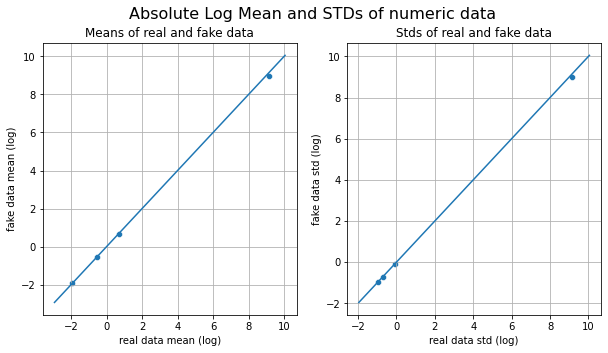

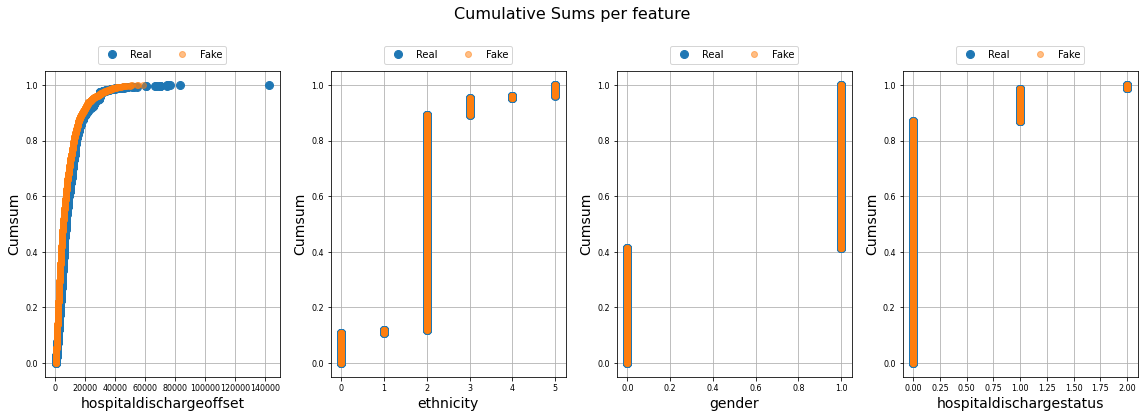

/home/dmf4ns/.local/lib/python3.9/site-packages/table_evaluator/table_evaluator.py:156: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  plot_df = pd.DataFrame({col: self.real[col].append(self.fake[col]), 'kind': ['real'] * self.n_samples + ['fake'] * self.n_samples})


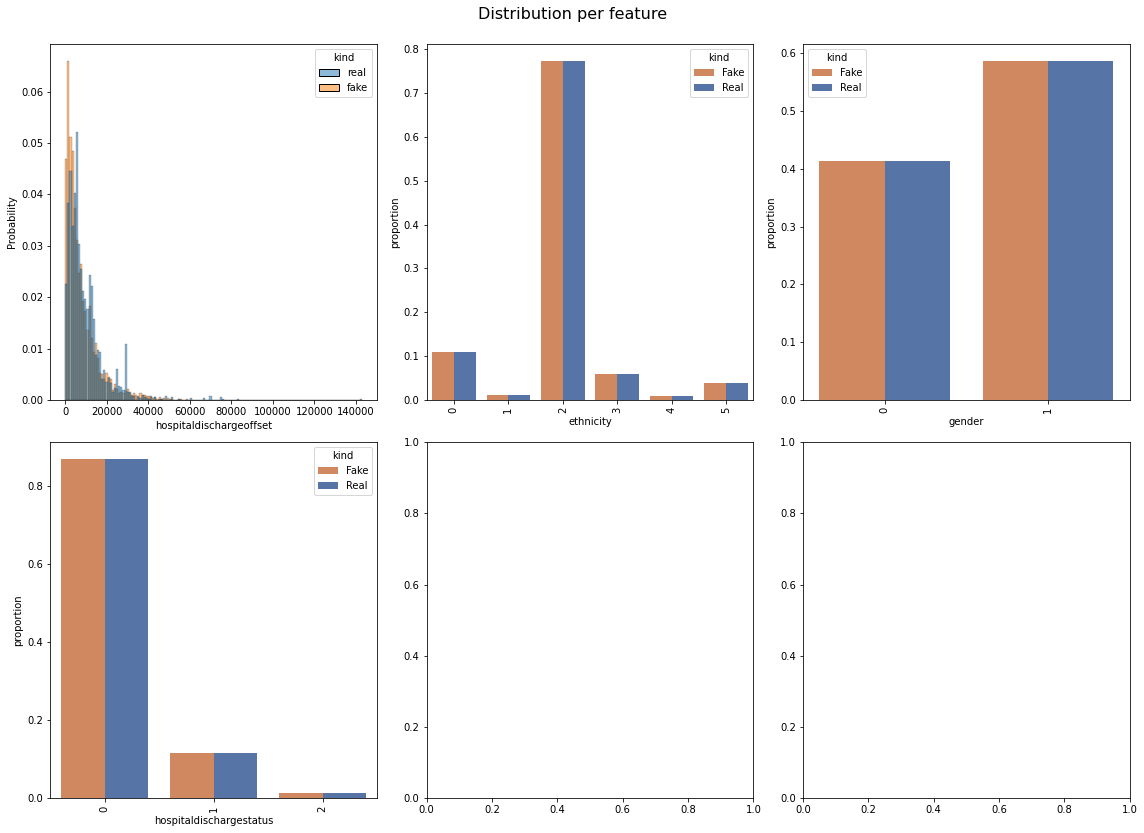

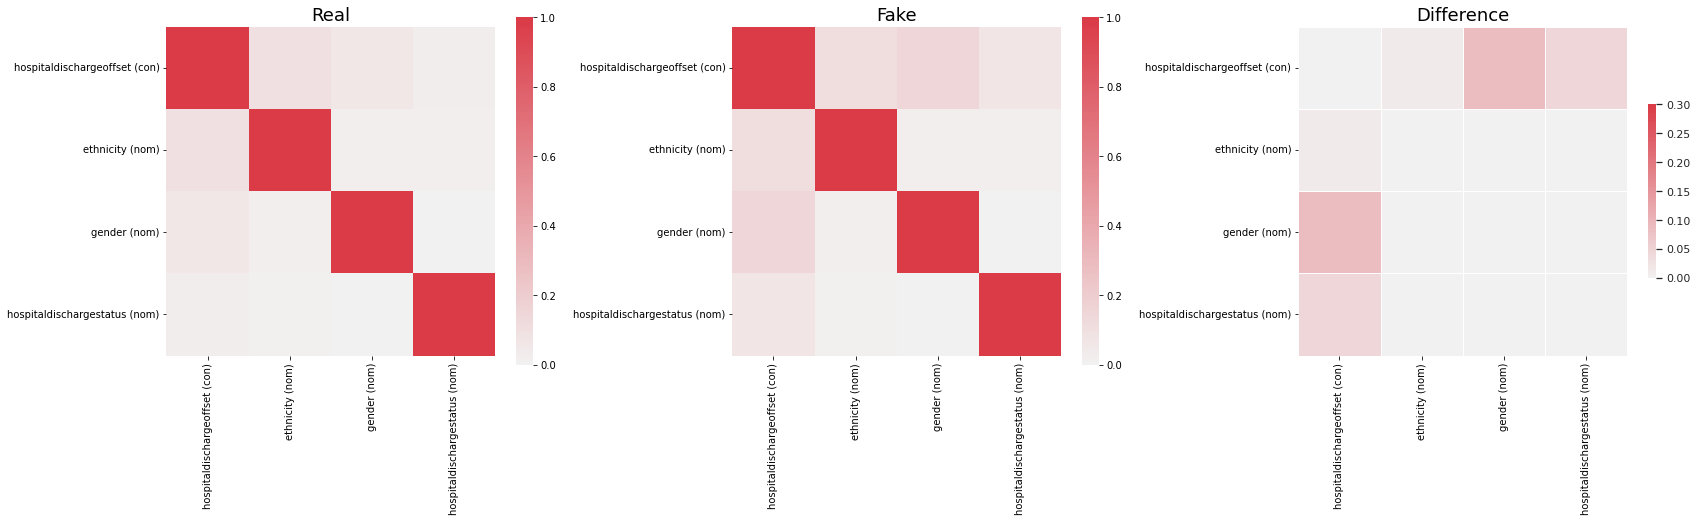

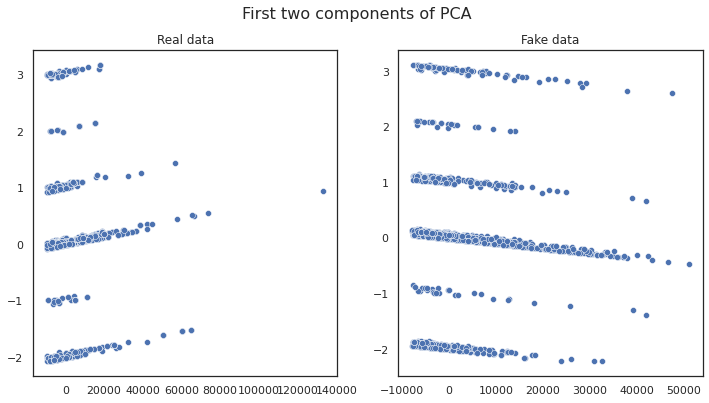

In [25]:
table_evaluator.visual_evaluation()

**Distribute**
https://www.tensorflow.org/tutorials/distribute/custom_training

In [26]:
mirrored_strategy = tf.distribute.MirroredStrategy()
print('Number of devices: {}'.format(mirrored_strategy.num_replicas_in_sync))

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
Number of devices: 2


In [27]:
# Create a checkpoint directory to store the checkpoints.
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")

In [28]:
#with mirrored_strategy.scope():
dist_gan = ConditionalGAN(noise_dim=50,
                 data_shape=len(cont_feats),
                 num_classes=all_labels[:1].shape[1], 
                 d_learning_rate=1e-6, 
                 g_learning_rate=1e-6, 
                 batch_size=64, 
                 start_epoch=0,
                 verbose = True, distribute = 'D') # added the distributed flag in the CGAN class

  #loss_obj = tf.keras.losses.BinaryCrossentropy(reduction=tf.keras.losses.Reduction.NONE)
  #loss = tf.reduce_sum(loss_obj(labels, predictions)) * (1. / global_batch_size)

dist_gan.compile(loss_fn=keras.losses.BinaryCrossentropy(from_logits=True))

Generator input dim:  61
Dicrimination input dim:  12
Instructions for updating:
use distribute.MultiWorkerMirroredStrategy instead
INFO:tensorflow:Single-worker MultiWorkerMirroredStrategy with local_devices = ('/device:GPU:0', '/device:GPU:1'), communication = CommunicationImplementation.AUTO
Number of devices: 2
Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 12)]              0         
                                                                 
 dense_8 (Dense)             (None, 64)                832       
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 64)                0         
                                                                 
 dropout_3 (Dropout)         (None, 64)                0         
                                                                 


In [29]:
dist_gan.fit(dataset, epochs=2000, verbose=True)

Epoch 1/2000
age_one_hot_labels1: Tensor("strided_slice_1:0", shape=(None, 1, 11), dtype=float32)
age_one_hot_labels2: Tensor("strided_slice_2:0", shape=(None,), dtype=float32)
age_one_hot_labels3: Tensor("strided_slice_3:0", shape=(None, 11), dtype=float32)


/usr/local/lib/python3.9/site-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


age_one_hot_labels1: Tensor("strided_slice_1:0", shape=(None, 1, 11), dtype=float32)
age_one_hot_labels2: Tensor("strided_slice_2:0", shape=(None,), dtype=float32)
age_one_hot_labels3: Tensor("strided_slice_3:0", shape=(None, 11), dtype=float32)
40/40 [==============================] - 1s 4ms/step - g_loss: 0.7633 - d_loss: 0.6912
Epoch 2/2000
40/40 [==============================] - 0s 4ms/step - g_loss: 0.7625 - d_loss: 0.6910
Epoch 3/2000
40/40 [==============================] - 0s 4ms/step - g_loss: 0.7622 - d_loss: 0.6908
Epoch 4/2000
40/40 [==============================] - 0s 4ms/step - g_loss: 0.7621 - d_loss: 0.6906
Epoch 5/2000
40/40 [==============================] - 0s 4ms/step - g_loss: 0.7619 - d_loss: 0.6904
Epoch 6/2000
40/40 [==============================] - 0s 4ms/step - g_loss: 0.7614 - d_loss: 0.6903
Epoch 7/2000
40/40 [==============================] - 0s 4ms/step - g_loss: 0.7607 - d_loss: 0.6900
Epoch 8/2000
40/40 [==============================] - 0s 4ms/step -

In [30]:
dist_age_eth, final_df = generate_table(df_feats, features = features, cont_feats = cont_feats)

______________________________
Generating:  99  data elements with categorical vars:  ('African American', 'Female', 'Alive')


/usr/local/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/tmp/ipykernel_24089/239525597.py:97: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_age_eth = df_age_eth.append(df_temp)
/tmp/ipykernel_24089/239525597.py:97: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_age_eth = df_age_eth.append(df_temp)
/tmp/ipykernel_24089/239525597.py:97: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_age_eth = df_age_eth.append(df_temp)


 
Generated statistics for continuous var < hospitaldischargeoffset >:
min:  111.1094937028829
mean:  7225.12459706822
max:  41066.77476555109
stdv:  7229.039443977454
 
Statistics of real data for continuous var < hospitaldischargeoffset >:
min:  240
mean:  8647.10101010101
max:  51993
stdv:  7928.211868015411
 
______________________________
Generating:  3  data elements with categorical vars:  ('African American', 'Female', 'Expired')
 
Generated statistics for continuous var < hospitaldischargeoffset >:
min:  3052.8546961955726
mean:  10319.03165625905
max:  14217.47045776993
stdv:  5142.528982535543
 
Statistics of real data for continuous var < hospitaldischargeoffset >:
min:  2093
mean:  7531.0
max:  10250
stdv:  3845.2466760924453
 
______________________________
Generating:  2  data elements with categorical vars:  ('African American', 'Female', 'nan')
 
Generated statistics for continuous var < hospitaldischargeoffset >:
min:  1686.5267958249897
mean:  2467.875962750986
max: 

/tmp/ipykernel_24089/239525597.py:97: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_age_eth = df_age_eth.append(df_temp)
/tmp/ipykernel_24089/239525597.py:97: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_age_eth = df_age_eth.append(df_temp)
/tmp/ipykernel_24089/239525597.py:97: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_age_eth = df_age_eth.append(df_temp)
/tmp/ipykernel_24089/239525597.py:97: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_age_eth = df_age_eth.append(df_temp)


 
Generated statistics for continuous var < hospitaldischargeoffset >:
min:  4887.409787725657
mean:  20398.740193085123
max:  47537.32969453931
stdv:  19255.281224990245
 
Statistics of real data for continuous var < hospitaldischargeoffset >:
min:  3802
mean:  4462.333333333333
max:  5783
stdv:  933.8523556870338
 
______________________________
Generating:  10  data elements with categorical vars:  ('Asian', 'Male', 'Alive')
 
Generated statistics for continuous var < hospitaldischargeoffset >:
min:  1456.618069857359
mean:  12201.977679056581
max:  39140.84408509731
stdv:  11285.834123169556
 
Statistics of real data for continuous var < hospitaldischargeoffset >:
min:  3557
mean:  7024.6
max:  14283
stdv:  3677.5833423594904
 
______________________________
Generating:  2  data elements with categorical vars:  ('Asian', 'Male', 'Expired')
 
Generated statistics for continuous var < hospitaldischargeoffset >:
min:  2271.9153772275895
mean:  3849.030692222528
max:  5426.146007217467

/tmp/ipykernel_24089/239525597.py:97: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_age_eth = df_age_eth.append(df_temp)
/tmp/ipykernel_24089/239525597.py:97: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_age_eth = df_age_eth.append(df_temp)
/tmp/ipykernel_24089/239525597.py:97: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_age_eth = df_age_eth.append(df_temp)
/tmp/ipykernel_24089/239525597.py:97: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_age_eth = df_age_eth.append(df_temp)


 
Generated statistics for continuous var < hospitaldischargeoffset >:
min:  166.6996419217321
mean:  9706.888617232811
max:  36670.73757866025
stdv:  8235.192356885778
 
Statistics of real data for continuous var < hospitaldischargeoffset >:
min:  85
mean:  8584.813725490196
max:  25488
stdv:  6173.937498064561
 
______________________________
Generating:  8  data elements with categorical vars:  ('Caucasian', 'Female', 'nan')
 
Generated statistics for continuous var < hospitaldischargeoffset >:
min:  1335.5964125087485
mean:  9600.19869465637
max:  19442.052441745996
stdv:  6682.285580529437
 
Statistics of real data for continuous var < hospitaldischargeoffset >:
min:  815
mean:  9036.75
max:  31629
stdv:  13071.088724260882
 
______________________________
Generating:  937  data elements with categorical vars:  ('Caucasian', 'Male', 'Alive')
 
Generated statistics for continuous var < hospitaldischargeoffset >:
min:  63.836082893118146
mean:  6233.691800206861
max:  45507.93943494

/tmp/ipykernel_24089/239525597.py:97: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_age_eth = df_age_eth.append(df_temp)
/tmp/ipykernel_24089/239525597.py:97: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_age_eth = df_age_eth.append(df_temp)
/tmp/ipykernel_24089/239525597.py:97: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_age_eth = df_age_eth.append(df_temp)
/tmp/ipykernel_24089/239525597.py:97: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_age_eth = df_age_eth.append(df_temp)


 
Generated statistics for continuous var < hospitaldischargeoffset >:
min:  745.1353967213072
mean:  7216.831450900746
max:  35406.4117539376
stdv:  8953.03653221356
 
Statistics of real data for continuous var < hospitaldischargeoffset >:
min:  2838
mean:  10842.0
max:  28637
stdv:  6276.001997025389
 
______________________________
Generating:  30  data elements with categorical vars:  ('Hispanic', 'Female', 'Alive')
 
Generated statistics for continuous var < hospitaldischargeoffset >:
min:  272.57041498669423
mean:  5985.686791361236
max:  33469.553925067186
stdv:  6767.28892839634
 
Statistics of real data for continuous var < hospitaldischargeoffset >:
min:  239
mean:  8684.733333333334
max:  48882
stdv:  10587.250968132485
 
______________________________
Generating:  1  data elements with categorical vars:  ('Hispanic', 'Female', 'Expired')
 
Generated statistics for continuous var < hospitaldischargeoffset >:
min:  2668.562715727836
mean:  2668.562715727836
max:  2668.5627157

/tmp/ipykernel_24089/239525597.py:97: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_age_eth = df_age_eth.append(df_temp)
/tmp/ipykernel_24089/239525597.py:97: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_age_eth = df_age_eth.append(df_temp)
/tmp/ipykernel_24089/239525597.py:97: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_age_eth = df_age_eth.append(df_temp)
/tmp/ipykernel_24089/239525597.py:97: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_age_eth = df_age_eth.append(df_temp)


Generating:  85  data elements with categorical vars:  ('Hispanic', 'Male', 'Alive')
 
Generated statistics for continuous var < hospitaldischargeoffset >:
min:  117.85520760831423
mean:  10989.166427513686
max:  38636.76784723997
stdv:  8105.9916151431935
 
Statistics of real data for continuous var < hospitaldischargeoffset >:
min:  1191
mean:  9563.576470588236
max:  66499
stdv:  8156.474991760294
 
______________________________
Generating:  30  data elements with categorical vars:  ('Hispanic', 'Male', 'Expired')
 
Generated statistics for continuous var < hospitaldischargeoffset >:
min:  523.1722351950593
mean:  12780.365123926895
max:  38119.89178335667
stdv:  9293.362311064533
 
Statistics of real data for continuous var < hospitaldischargeoffset >:
min:  72
mean:  10744.566666666668
max:  25659
stdv:  5955.695770623464
 
______________________________
Generating:  4  data elements with categorical vars:  ('Hispanic', 'Male', 'nan')
 
Generated statistics for continuous var < h

/tmp/ipykernel_24089/239525597.py:97: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_age_eth = df_age_eth.append(df_temp)
/tmp/ipykernel_24089/239525597.py:97: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_age_eth = df_age_eth.append(df_temp)
/tmp/ipykernel_24089/239525597.py:97: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_age_eth = df_age_eth.append(df_temp)
/tmp/ipykernel_24089/239525597.py:97: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_age_eth = df_age_eth.append(df_temp)


 
______________________________
Generating:  21  data elements with categorical vars:  ('Native American', 'Male', 'Alive')
 
Generated statistics for continuous var < hospitaldischargeoffset >:
min:  254.10520324774552
mean:  7183.190611301583
max:  23124.077495872974
stdv:  5673.898883877956
 
Statistics of real data for continuous var < hospitaldischargeoffset >:
min:  1476
mean:  13690.190476190477
max:  24979
stdv:  8244.47481141763
 
______________________________
Generating:  11  data elements with categorical vars:  ('Other/Unknown', 'Female', 'Alive')
 
Generated statistics for continuous var < hospitaldischargeoffset >:
min:  1675.8819338511676
mean:  8780.824705618179
max:  23853.99567076564
stdv:  6218.798134355028
 
Statistics of real data for continuous var < hospitaldischargeoffset >:
min:  2028
mean:  9436.181818181818
max:  27181
stdv:  8491.806412581504
 
______________________________
Generating:  4  data elements with categorical vars:  ('Other/Unknown', 'Female', 

/tmp/ipykernel_24089/239525597.py:97: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_age_eth = df_age_eth.append(df_temp)
/tmp/ipykernel_24089/239525597.py:97: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_age_eth = df_age_eth.append(df_temp)
/tmp/ipykernel_24089/239525597.py:97: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_age_eth = df_age_eth.append(df_temp)
/tmp/ipykernel_24089/239525597.py:97: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_age_eth = df_age_eth.append(df_temp)


 
______________________________
Generating:  73  data elements with categorical vars:  ('Other/Unknown', 'Male', 'Alive')
 
Generated statistics for continuous var < hospitaldischargeoffset >:
min:  606.2315589901991
mean:  10252.60624594161
max:  46559.076146662235
stdv:  9609.964970798219
 
Statistics of real data for continuous var < hospitaldischargeoffset >:
min:  218
mean:  7509.835616438356
max:  27725
stdv:  6082.353989630152
 
______________________________
Generating:  7  data elements with categorical vars:  ('Other/Unknown', 'Male', 'Expired')
 
Generated statistics for continuous var < hospitaldischargeoffset >:
min:  2772.8859315980226
mean:  18775.86925752594
max:  36155.310230106115
stdv:  13249.03542230052
 
Statistics of real data for continuous var < hospitaldischargeoffset >:
min:  154
mean:  5394.0
max:  10198
stdv:  3725.943063747179
 


/tmp/ipykernel_24089/239525597.py:97: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_age_eth = df_age_eth.append(df_temp)
/tmp/ipykernel_24089/239525597.py:97: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_age_eth = df_age_eth.append(df_temp)


In [31]:
dist_age_eth.head()

,hospitaldischargeoffset,ethnicity,gender,hospitaldischargestatus
0,"21,242.5031",African American,Female,Alive
1,"17,085.5497",African American,Female,Alive
2,"3,671.7496",African American,Female,Alive
3,386.3884,African American,Female,Alive
4,"1,424.2499",African American,Female,Alive


In [32]:
df_feats.groupby(features).describe()

hospitaldischargeoffset  \
                                                                  count   
ethnicity        gender hospitaldischargestatus                           
African American Female Alive                                   99.0000   
                        Expired                                  3.0000   
                        nan                                      2.0000   
                 Male   Alive                                  158.0000   
                        Expired                                 12.0000   
                        nan                                      1.0000   
Asian            Female Alive                                   12.0000   
                        Expired                                  3.0000   
                 Male   Alive                                   10.0000   
                        Expired                                  2.0000   
Caucasian        Female Alive                                  767.0000   
                        Expired                                102.0000   
                        nan                                      8.0000   
                 Male   Alive                                  937.0000   
                        Expired                                134.0000   
                        nan                                     15.0000   
Hispanic         Female Alive                                   30.0000   
                        Expired                                  1.0000   
                        nan                                      1.0000   
                 Male   Alive                                   85.0000   
                        Expired                                 30.0000   
                        nan                                      4.0000   
Native American  Female Alive                                    3.0000   
                 Male   Alive                                   21.0000   
Other/Unknown    Female Alive                                   11.0000   
                        Expired                                  4.0000   
                        nan                                      2.0000   
                 Male   Alive                                   73.0000   
                        Expired                                  7.0000   

                                                                         \
                                                       mean         std   
ethnicity        gender hospitaldischargestatus                           
African American Female Alive                    8,647.1010  7,968.5593   
                        Expired                  7,531.0000  4,709.4461   
                        nan                      6,451.5000  3,860.0959   
                 Male   Alive                   14,198.3291 15,231.1539   
                        Expired                  8,830.1667  4,156.0047   
                        nan                      6,353.0000         NaN   
Asian            Female Alive                   13,196.1667  5,428.9452   
                        Expired                  4,462.3333  1,143.7309   
                 Male   Alive                    7,024.6000  3,876.5132   
                        Expired                    901.0000      0.0000   
Caucasian        Female Alive                    9,068.8396  7,563.0358   
                        Expired                  8,584.8137  6,204.4263   
                        nan                      9,036.7500 13,973.5816   
                 Male   Alive                    9,275.1964  9,784.5405   
                        Expired                 12,232.9851 13,716.9355   
                        nan                     10,842.0000  6,496.2792   
Hispanic         Female Alive                    8,684.7333 10,768.2427   
                        Expired                  2,234.0000         NaN   
                        nan                      7,887.0000         NaN 

**Evaluation**

In [33]:
dist_age_eth['data'] = 'GAN'

In [34]:
#https://pypi.org/project/table-evaluator/
from table_evaluator import load_data, TableEvaluator


In [35]:
final_df.head()

,hospitaldischargeoffset,ethnicity,gender,hospitaldischargestatus,ethnicity_code,gender_code,hospitaldischargestatus_code,ethnicity_African American,ethnicity_Asian,ethnicity_Caucasian,ethnicity_Hispanic,ethnicity_Native American,ethnicity_Other/Unknown,gender_Female,gender_Male,hospitaldischargestatus_Alive,hospitaldischargestatus_Expired,hospitaldischargestatus_nan
0,3962,Hispanic,Female,Alive,3,0,0,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,1.0000,0.0000,1.0000,0.0000,0.0000
1,1592,Caucasian,Male,Alive,2,1,0,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,1.0000,1.0000,0.0000,0.0000
2,4370,Caucasian,Female,Alive,2,0,0,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,1.0000,0.0000,1.0000,0.0000,0.0000
3,3583,Caucasian,Male,Alive,2,1,0,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,1.0000,1.0000,0.0000,0.0000
4,3583,Caucasian,Male,Alive,2,1,0,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,1.0000,1.0000,0.0000,0.0000


In [36]:
final_df['data'] = 'Truth'

In [37]:
df_true = final_df[cont_feats + features + ['data']].reset_index().drop('index', axis = True)

In [38]:
dist_age_eth.reset_index(level = 0, inplace = True)

In [39]:
df_all = df_true.append(dist_age_eth.drop('index', axis = 1)).reset_index(level = 0).drop('index', axis = 1)

/tmp/ipykernel_24089/3899109918.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all = df_true.append(dist_age_eth.drop('index', axis = 1)).reset_index(level = 0).drop('index', axis = 1)


In [40]:
table_evaluator = TableEvaluator(df_all[df_all['data'] == 'Truth'][cont_feats + features], 
                                 df_all[df_all['data'] == 'GAN'][cont_feats + features], cat_cols=features)


In [41]:
table_evaluator.evaluate(target_col='gender')


Classifier F1-scores and their Jaccard similarities::
                             f1_real  f1_fake  jaccard_similarity
index                                                            
DecisionTreeClassifier_fake   0.5315   0.5610              0.4014
DecisionTreeClassifier_real   0.8307   0.5217              0.3212
LogisticRegression_fake       0.6024   0.5925              0.6905
LogisticRegression_real       0.5571   0.4882              0.6414
MLPClassifier_fake            0.6024   0.6024              1.0000
MLPClassifier_real            0.5571   0.5571              1.0000
RandomForestClassifier_fake   0.5276   0.5492              0.3937
RandomForestClassifier_real   0.7756   0.5256              0.3281

Privacy results:
                                            result
Duplicate rows between sets (real/fake)  (1792, 0)
nearest neighbor mean                       0.0441
nearest neighbor std                        0.2218

Miscellaneous results:
                                  Resul

In [42]:
dist_age_eth[cont_feats + features].head()

,hospitaldischargeoffset,ethnicity,gender,hospitaldischargestatus
0,"21,242.5031",African American,Female,Alive
1,"17,085.5497",African American,Female,Alive
2,"3,671.7496",African American,Female,Alive
3,386.3884,African American,Female,Alive
4,"1,424.2499",African American,Female,Alive


In [43]:
df_true.append(dist_age_eth[cont_feats + features]).to_csv('dist_general_output.csv')

/tmp/ipykernel_24089/53622656.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_true.append(dist_age_eth[cont_feats + features]).to_csv('dist_age_eth_gender_output.csv')


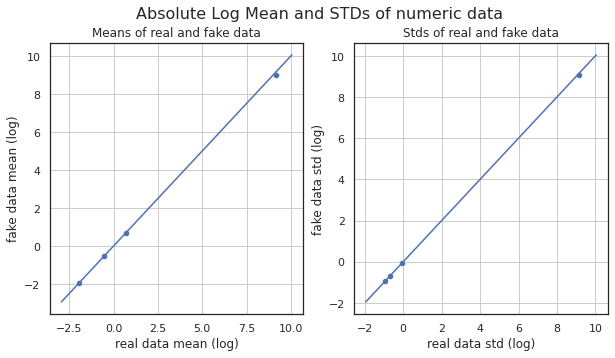

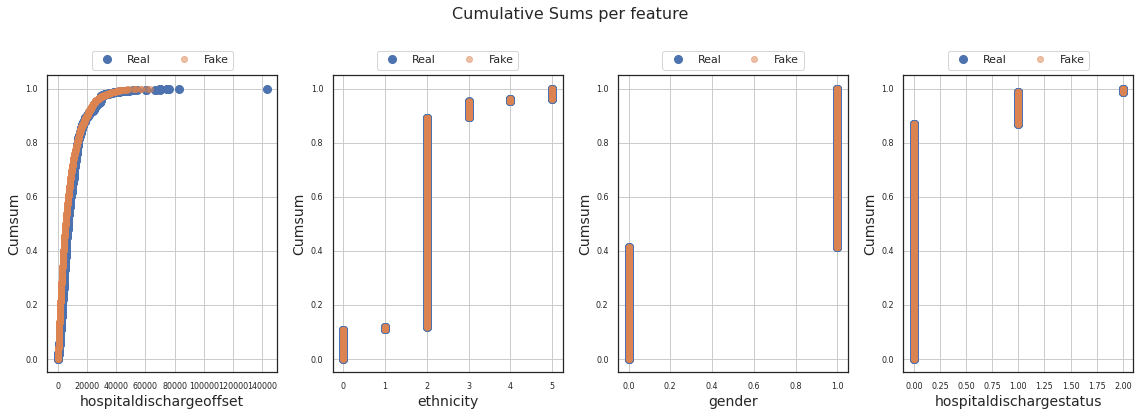

/home/dmf4ns/.local/lib/python3.9/site-packages/table_evaluator/table_evaluator.py:156: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  plot_df = pd.DataFrame({col: self.real[col].append(self.fake[col]), 'kind': ['real'] * self.n_samples + ['fake'] * self.n_samples})


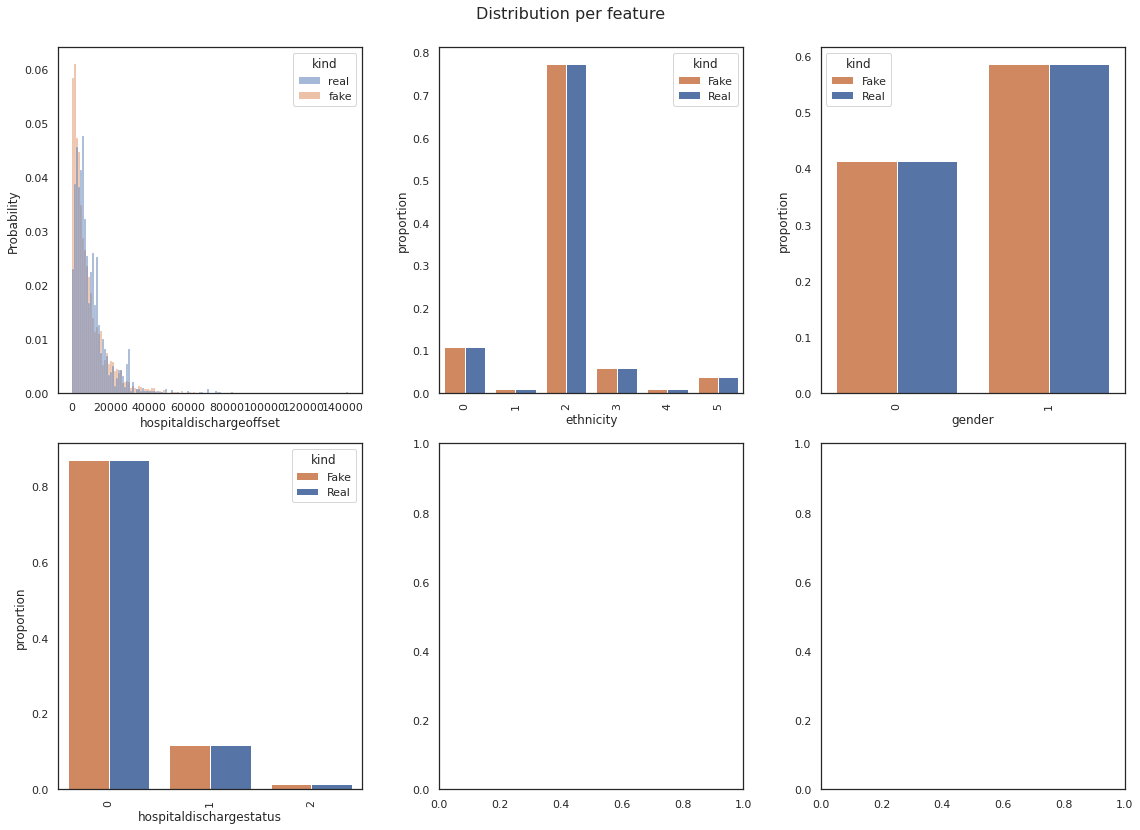

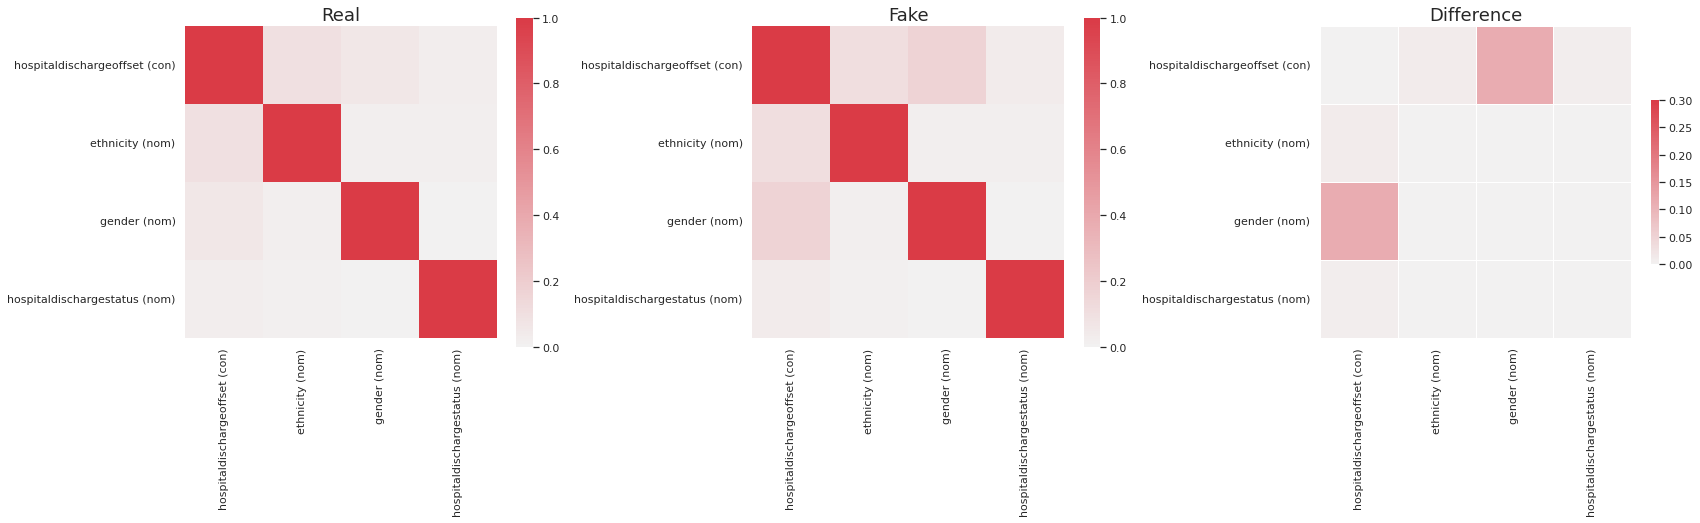

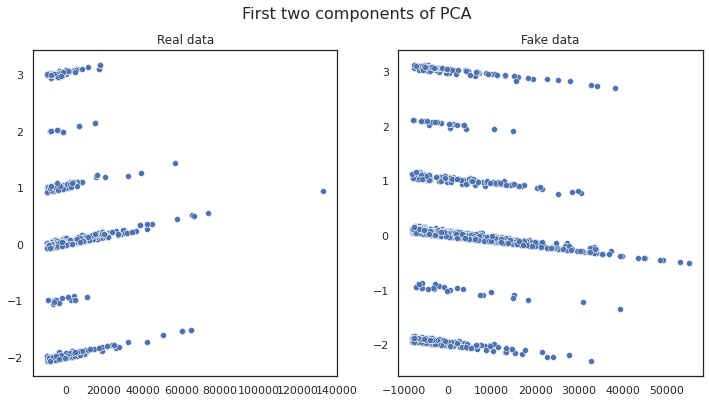

In [44]:
table_evaluator.visual_evaluation()